In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor

In [111]:
train = pd.read_csv('data/challenge3_train.csv', index_col='id')

In [35]:
features_bin = ['f0', 'f26'] # binary
features_nom_low = ['f5', 'f15'] # nominal low cardinality (<=3)
features_nom_high = ['f12', 'f28'] # >= 26
features_ordinal_low = ['f1', 'f2', 'f3', 'f6', 'f9', 'f11', 'f13', 'f17', 'f18', 'f19', 'f20', 'f21', 'f23', 'f24', 'f25', 'f27', 'f29']
features_ord_high = ['f4', 'f10', 'f14']
features_real = ['f7', 'f8', 'f16', 'f22', 'f30'] # real numbers

In [113]:
# another difficult column is f28 because of its high cardinality, if we were to use get_dummies, there would be an insane amount of columns
# in this column we will use target encoding, which is mean encoding with features to prevent bias
encoder = TargetEncoder()
train['f12'] = encoder.fit_transform(train['f12'], train['target'])
encoder = TargetEncoder()
train['f28'] = encoder.fit_transform(train['f28'], train['target'])

/home/samuelsen/.cache/pypoetry/virtualenvs/project-xBT1uwnk-py3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/samuelsen/.cache/pypoetry/virtualenvs/project-xBT1uwnk-py3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [114]:
train = pd.get_dummies(train, columns=features_nom_low)

In [112]:
train['f20'] = train['f20'].map(ord, na_action='ignore')
map_f20 = {key : value for value, key in enumerate(sorted(train['f20'].dropna().unique()))}
train['f20'] = train['f20'].map(map_f20)

In [115]:
# split train set into a train and test set
X = train.drop(['target'], axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [94]:
# drops imputing as xgboost handles it
#my_imputer = SimpleImputer()
#train_X = my_imputer.fit_transform(train_X)
#test_X = my_imputer.transform(test_X)

In [116]:
%%time

my_model = XGBRegressor()

# fit new df to model
my_model.fit(X_train, y_train, verbose=False)
# generate predictions
predictions = my_model.predict(X_test)
#calculate score
base_score = roc_auc_score(y_test, predictions)


CPU times: user 32.3 s, sys: 72 ms, total: 32.3 s
Wall time: 10.1 s


In [117]:
print(base_score)
#0.9061380644627911

#0.9098075714833503 - med label encoding på f12, f18, f20

0.9071318392231333


In [25]:
%%time
# Lets try dropping all negative columns
negative_col_names = negative_cols['column']

train_X_tuned = train_X.drop(labels=negative_col_names, axis=1)
test_X_tuned = test_X.drop(labels=negative_col_names, axis=1)

my_model = XGBRegressor()

# fit new df to model
my_model.fit(train_X_tuned, train_y, verbose=False)
# generate predictions
predictions = my_model.predict(test_X_tuned)
#calculate score
tuned_score = roc_auc_score(test_y, predictions)
print(tuned_score)


0.9021366572804613
CPU times: user 15.8 s, sys: 48.1 ms, total: 15.9 s
Wall time: 4.42 s


In [50]:
# Calculate ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def print_roc_curve(test_y, predictions):
    fpr, tpr, _ = roc_curve(test_y, predictions)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

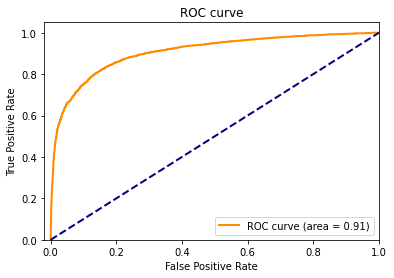

In [53]:
print_roc_curve(y_test, predictions)

In [54]:
%%time 
# now lets try tuning xgboost by letting it stop learning when the validation score stops improving, 
# and letting it cycle through the learning process until it does so

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# fit new df to model
my_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)
# generate predictions
predictions = my_model.predict(X_test)
#calculate score
tuned_score = roc_auc_score(y_test, predictions)
print(tuned_score)

0.9144174742016911
CPU times: user 1min 9s, sys: 190 ms, total: 1min 9s
Wall time: 20.6 s


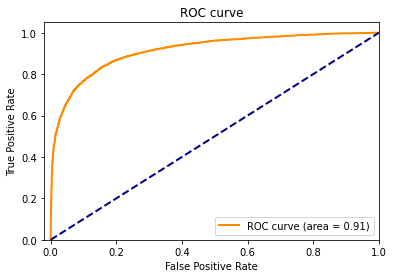

In [56]:
# we might have overfitted the model, and as a result we need to do cross validation
# lets plot the roc curve again
print_roc_curve(y_test, predictions)